### Train a Deep MLP on the MNIST Dataset and see if we can get over 98% precision. 

- Try searching for optimal learning rate by growing it exponentially, plotting the loss and finding the point where the loss shoots up.

- Try adding saves, checkpoints and plotting the learning curves using TensorBoard. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import time
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(tf.__version__)
print(keras.__version__)


2.11.0
2.11.0


In [3]:
# Get the data
(X_train_complete, Y_train_complete), (X_test, Y_test) = keras.datasets.mnist.load_data()

# create the validation set
X_valid, X_train = X_train_complete[:5000] / 255., X_train_complete[5000:] / 255.
Y_valid, Y_train = Y_train_complete[:5000], Y_train_complete[5000:]
X_test = X_test / 255. # Always ensure that we scale our test data. 

X_valid.shape

(5000, 28, 28)

### Building a Standard Model

In [4]:
# Building a standard_model using the sequential API
standard_model = keras.models.Sequential()

standard_model.add(keras.layers.Flatten(input_shape=[28, 28]))
standard_model.add(keras.layers.Dense(200, activation='relu'))
standard_model.add(keras.layers.Dense(100, activation='relu'))
standard_model.add(keras.layers.Dense(10, activation='softmax')) # Softmax as we are classifying, 10 because there are 10 classes. 

standard_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 200)               157000    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Looking at the weights and biases.

first_hidden = standard_model.layers[1]
weights, biases = first_hidden.get_weights()
# weights.shape
# biases.shape

In [6]:
# Compiling the model.

standard_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=[keras.metrics.SparseCategoricalAccuracy()]) # Using sparse categorical cross entropy as we are using integer labels not one hot encoding labels. 

### Creating Callbacks and TensorBoard Log Directories for Training. 

In [7]:
# TensorBoard associated code. 
root_log_dir = os.path.join(os.curdir, "logs")

# Create a specific sub directory to store the run data
def current_run_log_dir():
    '''Creates a current run directory'''
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_log_dir, run_id)


In [8]:
# Creating the callbacks
saver_cb = keras.callbacks.ModelCheckpoint("standard_mnist_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

my_logs = current_run_log_dir()
tensor_board_cb = keras.callbacks.TensorBoard(my_logs)

In [9]:
history = standard_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), callbacks=[saver_cb, early_stopping_cb, tensor_board_cb])

Epoch 1/100
   1/1719 [..............................] - ETA: 5:27 - loss: 2.2946 - sparse_categorical_accuracy: 0.1250

2023-01-26 21:21:37.751007: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1719/1719 [==============================] - 2s 979us/step - loss: 0.6416 - sparse_categorical_accuracy: 0.8302 - val_loss: 0.3155 - val_sparse_categorical_accuracy: 0.9100
Epoch 2/100
1719/1719 [==============================] - 2s 915us/step - loss: 0.2948 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.2432 - val_sparse_categorical_accuracy: 0.9346
Epoch 3/100
1719/1719 [==============================] - 2s 946us/step - loss: 0.2411 - sparse_categorical_accuracy: 0.9314 - val_loss: 0.2077 - val_sparse_categorical_accuracy: 0.9444
Epoch 4/100
1719/1719 [==============================] - 2s 914us/step - loss: 0.2064 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.1819 - val_sparse_categorical_accuracy: 0.9504
Epoch 5/100
1719/1719 [==============================] - 2s 921us/step - loss: 0.1806 - sparse_categorical_accuracy: 0.9477 - val_loss: 0.1602 - val_sparse_categorical_accuracy: 0.9558
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1598 - s

### Standard Model Testing

In [10]:
standard_model = keras.models.load_model("standard_mnist_model.h5")

standard_model.evaluate(X_test, Y_test)

313/313 [==============================] - 0s 496us/step - loss: 0.0660 - sparse_categorical_accuracy: 0.9795


[0.06598667055368423, 0.9794999957084656]

Using our standard model, we got an accuracy of 97%. Lets go and tune our model to improve this score to above 98%. There are several things we can tune with deep neural networks. 

- The number of layers.
- The number of nodes in a layer. 
- The learning rate. 
- The batch size. 
- The optimizer.
- The activation function. 
- The initialized weights. 

#

In [11]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Tuning The Learning Rate

- The standard LearningRateScheduler does not allow us to change when we implement our learning rate changes so we are going to use the custom one from the workbook.

In [12]:
class LearningRateIncreaser(keras.callbacks.Callback):
    ''' Increases the learning rate by a %.'''
    
    def __init__(self, increase):
        self.increase = increase
        self.learning_rates = []
        self.losses = []
    
    def on_batch_end(self, batch, logs):
        ''' Stores the current learning rate and loss, sets the new learning rate.'''
        self.learning_rates.append(keras.backend.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs['loss'])
        keras.backend.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.increase)



In [13]:
# Creating another model where we will tune the learning rate. 

lr_tester_model = keras.models.Sequential()

lr_tester_model.add(keras.layers.Flatten(input_shape=[28, 28]))
lr_tester_model.add(keras.layers.Dense(200, activation='relu'))
lr_tester_model.add(keras.layers.Dense(100, activation='relu'))
lr_tester_model.add(keras.layers.Dense(10, activation='softmax'))

lr_tester_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['accuracy']) # Starting really small. 
lr_tuner_cb = LearningRateIncreaser(increase=1.005) # Increasing by 0.5% each iteration. 

1719/1719 [==============================] - 2s 1ms/step - loss: 125463478272.0000 - accuracy: 0.5807 - val_loss: 2.3911 - val_accuracy: 0.1126
5.2636895


Text(0, 0.5, 'Loss')

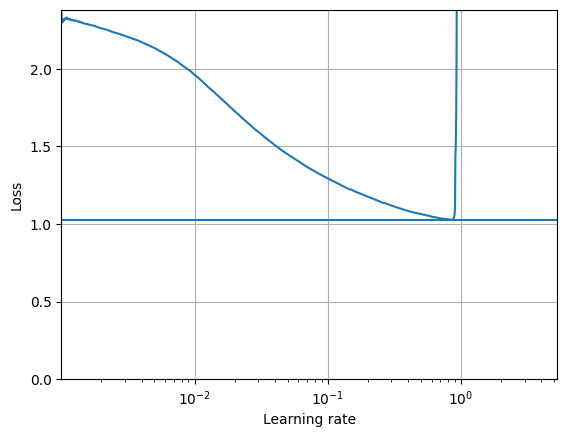

In [14]:
history = lr_tester_model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid), callbacks=[lr_tuner_cb])

print(max(lr_tuner_cb.learning_rates))

plt.plot(lr_tuner_cb.learning_rates, lr_tuner_cb.losses)
plt.gca().set_xscale('log')
plt.hlines(min(lr_tuner_cb.losses), min(lr_tuner_cb.learning_rates), max(lr_tuner_cb.learning_rates))
plt.axis([min(lr_tuner_cb.learning_rates), max(lr_tuner_cb.learning_rates), 0, lr_tuner_cb.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")


We can see that the loss shoots up rapidly around $8e^{-1}$, the rule of thumb is that the optimal learning rate is half of the maximum learning rate. So lets set our learning rate at $4e^{-1}$

In [15]:
# Creating the model and setting the tuned learning rate. 

lr_tuned_model = keras.models.Sequential()

lr_tuned_model.add(keras.layers.Flatten(input_shape=[28, 28]))
lr_tuned_model.add(keras.layers.Dense(200, activation='relu'))
lr_tuned_model.add(keras.layers.Dense(100, activation='relu'))
lr_tuned_model.add(keras.layers.Dense(10, activation='softmax'))

lr_tuned_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=4e-1), metrics=['accuracy']) # Tuned learning rate, we have deduced this number as 1/2 of the max learning rate. 

In [16]:
# Creating the callbacks
saver_cb = keras.callbacks.ModelCheckpoint("lr_tuned_mnist_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

my_logs = current_run_log_dir()
tensor_board_cb = keras.callbacks.TensorBoard(my_logs)

In [17]:
history = lr_tuned_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), callbacks=[saver_cb, early_stopping_cb, tensor_board_cb])

Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2498 - accuracy: 0.9229 - val_loss: 0.1088 - val_accuracy: 0.9672
Epoch 2/100
1719/1719 [==============================] - 2s 914us/step - loss: 0.1050 - accuracy: 0.9677 - val_loss: 0.0936 - val_accuracy: 0.9728
Epoch 3/100
1719/1719 [==============================] - 2s 911us/step - loss: 0.0776 - accuracy: 0.9760 - val_loss: 0.0888 - val_accuracy: 0.9732
Epoch 4/100
1719/1719 [==============================] - 2s 901us/step - loss: 0.0580 - accuracy: 0.9817 - val_loss: 0.0940 - val_accuracy: 0.9758
Epoch 5/100
1719/1719 [==============================] - 2s 929us/step - loss: 0.0496 - accuracy: 0.9847 - val_loss: 0.0861 - val_accuracy: 0.9780
Epoch 6/100
1719/1719 [==============================] - 2s 910us/step - loss: 0.0410 - accuracy: 0.9865 - val_loss: 0.0862 - val_accuracy: 0.9786
Epoch 7/100
1719/1719 [==============================] - 2s 905us/step - loss: 0.0330 - accuracy: 0.9893 - val_loss: 0.0

### Testing Tuned Learning Rate

In [18]:
# Testing the model with the tuned learning rate.

lr_tuned_model = keras.models.load_model('lr_tuned_mnist_model.h5')

lr_tuned_model.evaluate(X_test, Y_test)

313/313 [==============================] - 0s 501us/step - loss: 0.0851 - accuracy: 0.9758


[0.0850844755768776, 0.9757999777793884]

Tuning our learning rate gave us no gain in accuracy compared to the standard model, however there are still more things to tune. After reading the chapter, it seems like the number of layers is an important hyperparameter to look at, to put it like Aurélien "You get more bang for your buck" when you tune the layers. 

I am going to add one more layer to the network and see how it performs. 

#

#

In [19]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Tuning Layer Hyperparameter

In [20]:
# Creating a new model with an extra layer.

layers_tuned_model = keras.models.Sequential()

layers_tuned_model.add(keras.layers.Flatten(input_shape=[28, 28]))
layers_tuned_model.add(keras.layers.Dense(300, activation='relu'))
layers_tuned_model.add(keras.layers.Dense(200, activation='relu'))
layers_tuned_model.add(keras.layers.Dense(100, activation='relu'))
layers_tuned_model.add(keras.layers.Dense(10, activation='softmax'))

In [21]:
# Compile the model.

layers_tuned_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=['accuracy'])

In [22]:
# Creating the callbacks

saver_cb = keras.callbacks.ModelCheckpoint("layer_tuned_mnist_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

my_logs = current_run_log_dir()
tensor_board_cb = keras.callbacks.TensorBoard(my_logs)

In [23]:
# Training

history = layers_tuned_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), callbacks=[saver_cb, early_stopping_cb, tensor_board_cb])

Epoch 1/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6283 - accuracy: 0.8307 - val_loss: 0.2845 - val_accuracy: 0.9216
Epoch 2/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2668 - accuracy: 0.9229 - val_loss: 0.2187 - val_accuracy: 0.9372
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2089 - accuracy: 0.9393 - val_loss: 0.1702 - val_accuracy: 0.9520
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1717 - accuracy: 0.9500 - val_loss: 0.1467 - val_accuracy: 0.9584
Epoch 5/100
1719/1719 [==============================] - 3s 1ms/step - loss: 0.1461 - accuracy: 0.9577 - val_loss: 0.1324 - val_accuracy: 0.9644
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1266 - accuracy: 0.9627 - val_loss: 0.1196 - val_accuracy: 0.9686
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1109 - accuracy: 0.9674 - val_loss: 0.1118 - val_ac

### Testing Layers Tuned Model

In [24]:
layers_tuned_model = keras.models.load_model('layer_tuned_mnist_model.h5')

layers_tuned_model.evaluate(X_test, Y_test)

313/313 [==============================] - 0s 626us/step - loss: 0.0764 - accuracy: 0.9781


[0.07637351006269455, 0.9781000018119812]

A slight performance increase, lets look at the learning curves and see what is happening...

#

#

### Tuning the Number of Nodes

- We have looked at tuning our learning rate and the number of layers in the network but it appears to not be affecting our performance well. 

- When comparing the standard model to the model with more layers, it appears that we start to overfit our training data when we have 3 layers, which causes training to cut short as we have early stopping. 

- Having thought about this, I am going to experiment with the number of nodes in the first layer, without altering the number of layers in the network. This might allow us to increase the complexity of the network, without increasing it so much that we over fit the data early (like in the network with 3 hidden layers).

In [39]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [40]:
# Creating a model with more layers in the first layer of the network.

node_tuned_model = keras.models.Sequential()

node_tuned_model.add(keras.layers.Flatten(input_shape=[28, 28]))
node_tuned_model.add(keras.layers.Dense(300, activation='relu'))
node_tuned_model.add(keras.layers.Dense(100, activation='relu'))
node_tuned_model.add(keras.layers.Dense(10, activation='softmax'))

In [41]:
node_tuned_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=['accuracy']) # Standard learning rate as that performed better. 

In [42]:
# Creating the callbacks
saver_cb = keras.callbacks.ModelCheckpoint("node_tuned_mnist_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

my_logs = current_run_log_dir()
tensor_board_cb = keras.callbacks.TensorBoard(my_logs)

In [43]:
node_tuned_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid), callbacks=[saver_cb, early_stopping_cb, tensor_board_cb])

Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6215 - accuracy: 0.8427 - val_loss: 0.3067 - val_accuracy: 0.9142
Epoch 2/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2939 - accuracy: 0.9157 - val_loss: 0.2436 - val_accuracy: 0.9310
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2415 - accuracy: 0.9307 - val_loss: 0.2033 - val_accuracy: 0.9440
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2064 - accuracy: 0.9408 - val_loss: 0.1803 - val_accuracy: 0.9516
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1805 - accuracy: 0.9486 - val_loss: 0.1605 - val_accuracy: 0.9546
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1600 - accuracy: 0.9543 - val_loss: 0.1478 - val_accuracy: 0.9606
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1432 - accuracy: 0.9600 - val_loss: 0.1352 - val_ac

### Testing Node Tuned Model

In [44]:
node_tuned_model = keras.models.load_model("node_tuned_mnist_model.h5")

node_tuned_model.evaluate(X_test, Y_test)

313/313 [==============================] - 0s 676us/step - loss: 0.0638 - accuracy: 0.9801


[0.06384775042533875, 0.9800999760627747]

### There we are at 98%.

- Although we tried to tweak the learning rate, it appears that there might be some error in my computations, as the default learning rate produced the highest score. 

- It could be worth exploring "automatic" hyperparameter tuners. 

- I learned that having only 200 nodes in the first layer was stopping my network from getting to 98%, although the gap is miniscule the network is able to extract a deeper representation of the data during training with 300 nodes in the first network. 

- However adding another layer into the network did not help the situation. This problem puzzles me at the moment as I was expecting the extra layer to allow the network to further represent the data, even with 300 nodes in the first layer, it appears that having that second layer reduces the accuracy of the network. However, I cannot explain it at the moment in time. 